In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import notebook, tqdm
import seaborn as sns
from collections import Counter
import pandas as pd

In [75]:
root = "/home/ubuntu/suad_23/"
imgs = list(sorted(os.listdir(os.path.join(root, "inputs"))))
targets = list(sorted(os.listdir(os.path.join(root,
                                "semantic_annotations"))))
len(imgs)

1786

## Check image sizes

In [6]:
width = []
height = []

for file in tqdm(imgs):
    img = Image.open(root + "/inputs/"+file)
    img.load()
    w, h = img.size
    width.append(w)
    height.append(h)

100%|██████████| 1786/1786 [01:15<00:00, 23.63it/s]


In [11]:
Counter(height)

Counter({2200: 1431, 2150: 160, 2250: 195})

In [12]:
Counter(width)

Counter({1550: 1162, 1500: 430, 1400: 194})

<AxesSubplot: xlabel='width', ylabel='height'>

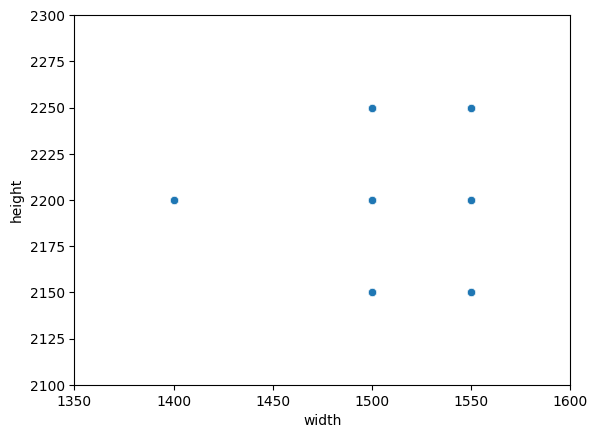

In [9]:
plt.xlim(min(width)-50, max(width)+50)
plt.ylim(min(height)-50, max(height)+50)
plt.xlabel("width")
plt.ylabel("height")
sns.scatterplot(x=width, y=height)

## Check classes

In [ ]:
values = np.empty(0)
for file in tqdm(targets):
    img = Image.open(root + "/semantic_annotations/"+file)
    img.load()
    vals = np.unique(img)
    values = np.append(values, vals)

np.unique(values)

In [76]:
classes = [i for i in range(16)]+[255]

In [77]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

In [78]:
class masks(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files
        self.imgs = list(sorted(os.listdir(os.path.join(root, "semantic_annotations"))))

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, "semantic_annotations", self.imgs[idx])
        img = Image.open(img_path)
        img = np.array(img)
        if self.transforms is not None:
            img = self.transforms(image=img, mask=img)
            img = img["mask"]
        return img, self.imgs[idx]  # for saving purposes

    def __len__(self):
        return len(self.imgs)


def get_transform(size=(256, 384)):
    augs = []
    augs.append(A.Resize(*size))
    return A.Compose(augs)


In [79]:
ds = masks(root, get_transform(size=(512, 512)))
loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)

In [80]:
percentages = {i: np.zeros(len(loader)) for i in classes}

In [81]:
pixel_no = 512**2
for i, data in enumerate(loader):
    unique, counts = np.unique(data[0], return_counts=True)
    for pixel, count in zip(unique, counts):
        percentages[pixel][i] = count/pixel_no

In [117]:
df = pd.DataFrame.from_dict(percentages)

In [118]:
colnames = ["WATER", "ASPHALT", "GRASS",
            "HUMAN", "ANIMAL", "HIGH VEGETATION", "GROUND VEHICLE", "FAÇADE", "WIRE", "GARDEN FURNITURE", "CONCRETE", "ROOF", "GRAVEL", "SOIL", "PRIMEAIR PATTERN", "SNOW", "UNKNOWN"]
df.columns = colnames

(0.0, 1.0)

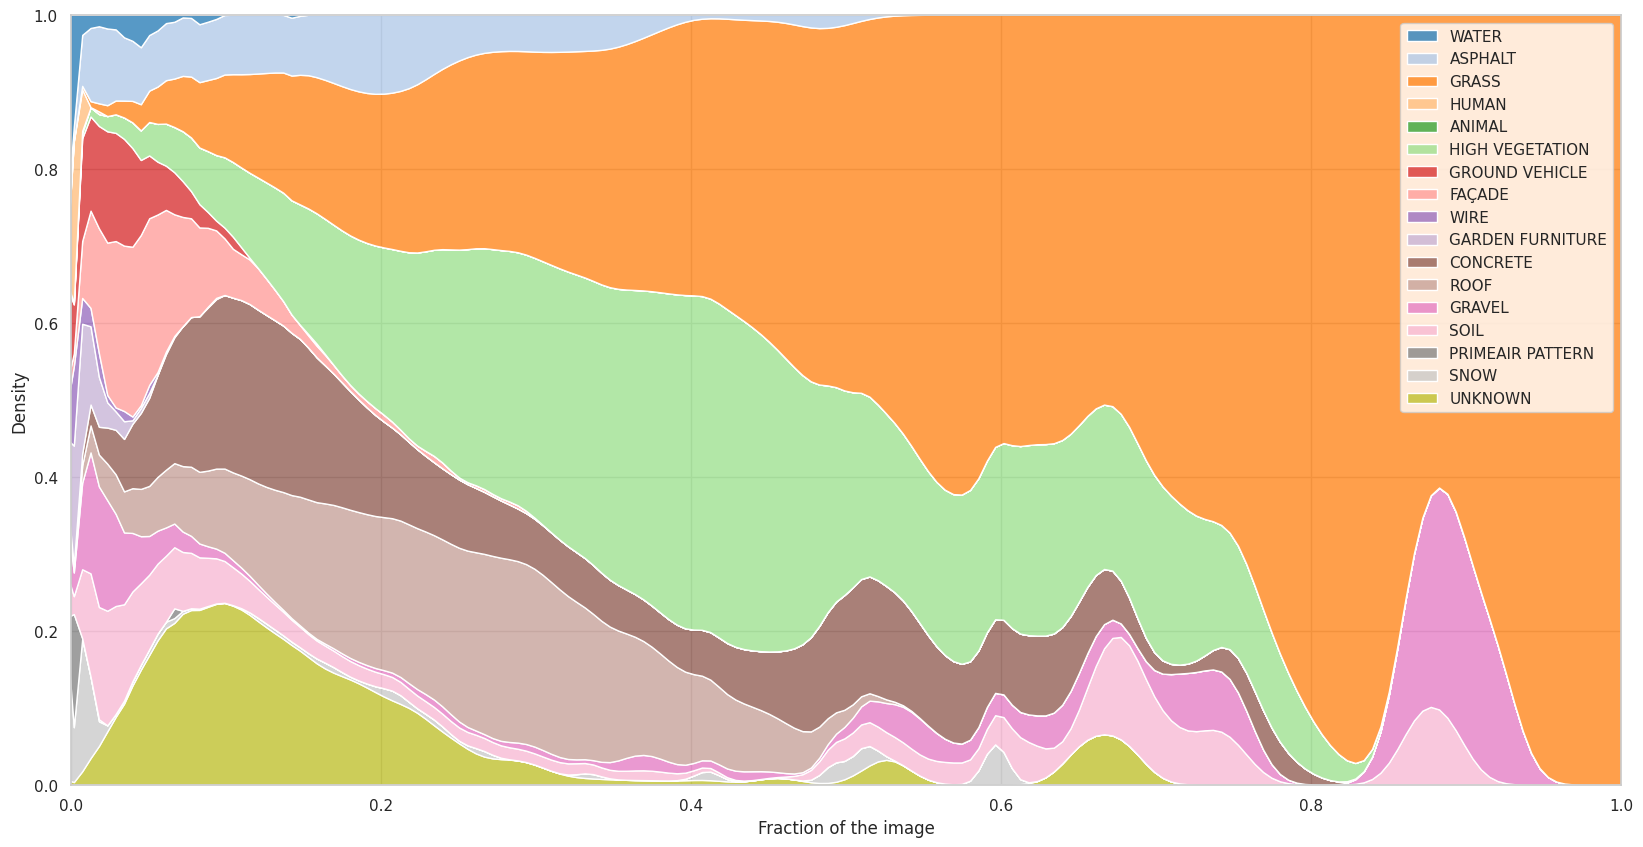

In [129]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set_style("whitegrid")
sns.kdeplot(df, multiple="fill", palette="tab20")
plt.xlabel("Fraction of the image")
plt.xlim(0, 1)